In [1]:
from PyPDF2 import PdfFileWriter, PdfFileReader
import string
from collections import Counter
from tqdm import tqdm

def add_wordcount_to_dict(words_from_page, total_word_count):
    '''Update the count of total words within the text'''
    for key in words_from_page.keys():
        if key not in total_word_count.keys():
            total_word_count[key] = words_from_page[key]
        else:
            total_word_count[key] += words_from_page[key]
    

# output = PdfFileWriter()
input1 = PdfFileReader(open("domCasmurro.pdf", "rb"))
text_file = open("book_content.txt", "w", encoding='utf-8')


total_word_count = dict()

totalNumPages = input1.numPages

for page in tqdm(range(totalNumPages)):
    #extrai o texto de uma página
    page_text = input1.getPage(page).extractText()
    text_file.write(page_text)
    #remove '\n' e pontuações
    page_content = page_text.lower().replace('\n', '').translate(str.maketrans('', '', string.punctuation)).split(' ')
    dict_words_page = Counter(page_content)
    add_wordcount_to_dict(dict_words_page, total_word_count)

100%|██████████| 128/128 [00:03<00:00, 34.93it/s]


In [2]:
written_file= open("book_content.txt", "r")
read_written = written_file.read()

In [3]:
read_written.split('\n')

[' Dom Casmurro',
 '  Texto de referência:',
 ' Obras Completas',
 ' de Machado de Assis, vol. I,',
 ' Nova Aguilar, Rio de Janeiro, 1994.',
 '    Publicado originalmente pela Editor',
 'a Garnier, Rio de Janeiro, 1899.',
 '                     CAPÍTULO PRIMEIRO DO TÍTULO',
 '   Uma noite destas, vindo da cidade para ',
 'o Engenho Novo, encontrei no trem da ',
 'Central um rapaz aqui do bairro, que eu conheço de vista e de chapéu. ',
 'Cumprimentou-me, sentou-se ao pé de ',
 'mim, falou da Lua e dos ministros, e ',
 'acabou recitando-me versos. A viagem er',
 'a curta, e os versos pode ser que não ',
 'fossem inteiramente maus. Suce',
 'deu, porém, que, como eu estava cansado, fechei ',
 'os olhos três ou quatro vezes; tanto bastou para que ele interrompesse a leitura e ',
 'metesse os versos no bolso. ',
 '   Š Continue, disse eu acordando. ',
 '   Š Já acabei, murmurou ele.    Š São muito bonitos. ',
 '   Vi-lhe fazer um gesto para tirá-los outr',
 'a vez do bolso, mas não passou do

In [4]:
import operator
import nltk
from nltk.corpus import stopwords
total_word_count
sorted_words = sorted(total_word_count.items(), key=operator.itemgetter(1), reverse=True)
# map(total_word_count.pop, ['a','c'])
# nltk.Text(read_written)
type(read_written)

str

In [5]:
sw = stopwords.words('portuguese')
tokens = nltk.word_tokenize(read_written.lower())
tokens = [token  for token in tokens if token.isalpha() and token not in sw]
text = nltk.Text(tokens)

In [6]:
text.collocations()

josé dias; prima justina; tio cosme; pode ser; padre cabral; outra
vez; alguma coisa; alguns instantes; outra coisa; dia seguinte; muita
vez; engenho novo; ser padre; rio janeiro; protonotário apostólico;
mana glória; dom casmurro; sala visitas; santa mônica; santos óleos


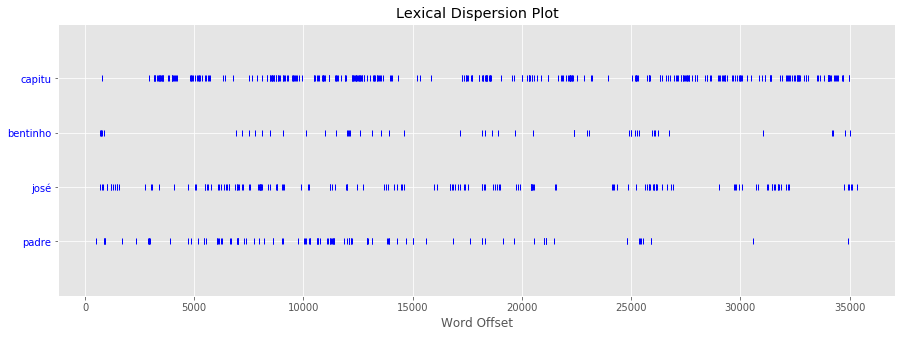

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure(figsize=(15,5))
text.dispersion_plot(["capitu", "bentinho", "josé", "padre"])

In [8]:
def ttr(text):
    '''
    Lexical diversity measured by Type-Token Ratio, measured using the number of unique words 
    and the total number of words in the whole text
    
    This kind of measure is bad to compare texts of different lengths.
    For details see here https://en.wikipedia.org/wiki/Lexical_diversity
    '''
    return round(len(set(text))/len(text),2)

ttr(text)

0.25

In [14]:
import numpy as np
from tqdm import tqdm
from scipy.optimize import curve_fit

####################
#### Parameters ####
####################
N_SUBSAMPLES = 100
sample_range = range(100,500,25)


def select_random_subsample(text_from_tokens, sample_size):
    return np.random.choice(np.array(text_from_tokens), size = sample_size, replace = False)

def ttr_subsample(tokens):
    return len(set(tokens))/len(tokens)

def TTR_function(x, D):
    return np.multiply((D/x),((1+2*x/D)**(1/2) - 1), dtype = np.float)

def compute_D(text_from_tokens):
    '''
    This algorithm was implemented based on page 328 of the following paper:
    https://www.researchgate.net/publication/283149921_Measuring_Vocabulary_Diversity_Using_Dedicated_Software
    '''
    best_fit_ds = list()
    best_fit_ds_std = list()

    for i in range(0,3):
        ttr_step_list = list()
        std_ttr_step_list = list()
        D_sample = list()

        for N in tqdm(sample_range):
            ttr_sample_list = list()

            for i in range(N_SUBSAMPLES):
                random_tokens = select_random_subsample(text_from_tokens, N)
                ttr = ttr_subsample(random_tokens)
                ttr_sample_list.append(ttr)

            ttr_sample_list = np.array(ttr_sample_list)
            mean_ttr = ttr_sample_list.mean()        
            std_ttr = ttr_sample_list.std()
            ttr_step_list.append(mean_ttr); std_ttr_step_list.append(std_ttr)

            D = - N*(mean_ttr**2)/(2*(mean_ttr - 1))
            D_sample.append(D)

        D_avg = np.array(D_sample).mean()
        D_std = np.array(D_sample).std()
        best_D_fit, best_D_std = curve_fit(TTR_function, xdata = np.array(sample_range), ydata = np.array(ttr_step_list))
        best_fit_ds.append(best_D_fit)
        best_fit_ds_std.append(best_D_std)
        
    best_fit_ds = np.array(best_fit_ds)
    best_fit_ds_std = np.array(best_fit_ds_std)
    
    return best_fit_ds.mean(), best_fit_ds_std.mean() 

d, std_d = compute_D(text) # D is known as vocabulary diversity

100%|██████████| 16/16 [01:09<00:00,  4.31s/it]


In [13]:
ds, std_ds

(810.2682935908306, 222.62178826635537)

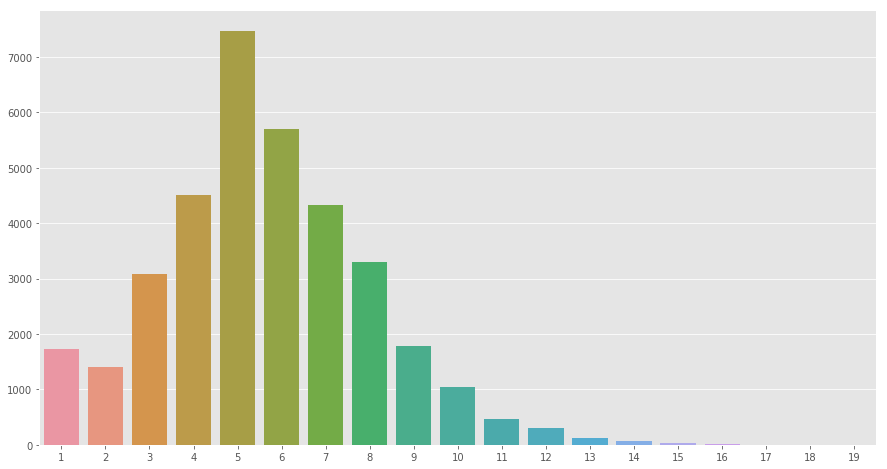

In [31]:
# count the number of words
from collections import defaultdict
import seaborn as sb

def count_words(text):
    length_count =  defaultdict(int)

    for word in text:
        number_of_chars = len(word)
        length_count[number_of_chars]+=1

    plt.figure(figsize=(15,8))
    sb.barplot(x = list(length_count.keys()), y = list(length_count.values()));
    
    return length_count

_ = count_words(text)

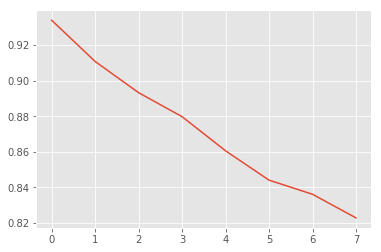

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(ttr_step_list)

In [194]:
sw = stopwords.words('portuguese')
frequency = nltk.FreqDist(w.lower() for w in tokens if w not in sw)

In [116]:
frequency.pop(',')
frequency.pop('.')
frequency.pop('š')
frequency.pop('?')
frequency.pop('é')
frequency.pop('!')
frequency.pop(';')
frequency.pop('...')
frequency.pop(':')
frequency.pop('a')

FreqDist({'capitu': 325, 'não': 307, 'mãe': 222, 'dias': 188, 'tudo': 186, 'capítulo': 184, 'casa': 167, 'ser': 162, 'o': 161, 'josé': 159, ...})

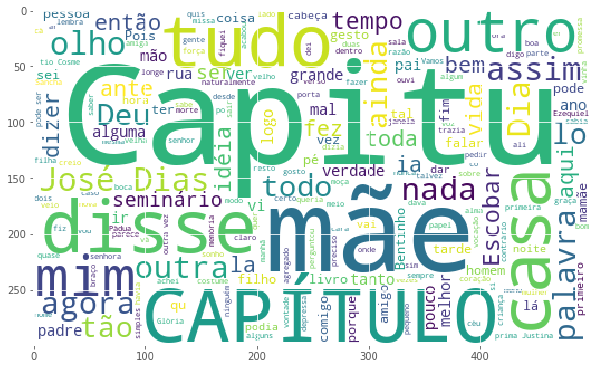

In [195]:
from wordcloud import WordCloud

wc = WordCloud(stopwords = set(sw), background_color='white', contour_color='black', random_state=5, height=300, width=500).generate(read_written)
plt.figure(figsize=(10,20))
plt.imshow(wc)

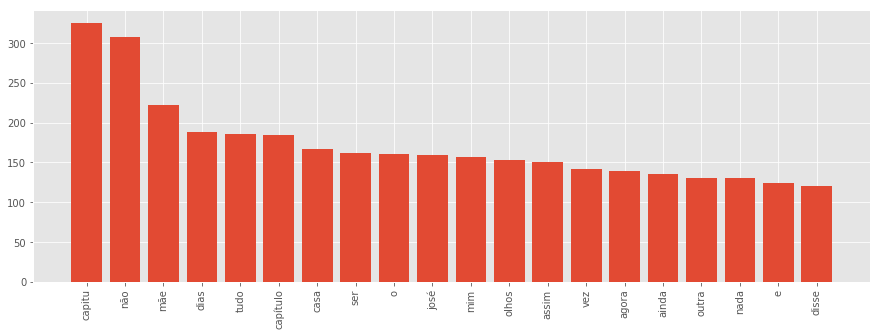

In [173]:
import matplotlib.pyplot as plt
import seaborn as sb
from collections import Counter
plt.style.use('ggplot')
%matplotlib inline

k = Counter(frequency)
k.most_common(20)
top_k = {}
for word, value in k.most_common(20):
    top_k[word] = value

plt.figure(figsize=(15,5))
plt.bar(range(len(top_k)), list(top_k.values()), align='center')
plt.xticks(range(len(top_k)), list(top_k.keys()), rotation = 'vertical')
plt.show()

array([50.03982258])

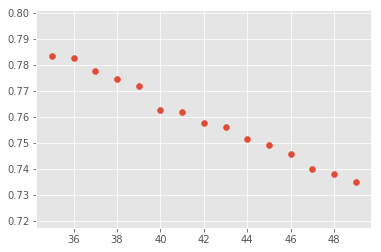

In [110]:
from scipy.optimize import curve_fit

def func(x, D):
    return np.multiply((D/x),((1+2*x/D)**(1/2) - 1), dtype = np.float)

# def func(x, a, b, c):
#     return a * np.exp(-b * x) + c

n = np.array([N for N in range(35,50)])
noise = 0.0015*np.random.normal(size = n.shape)
mean_ttr = func(n, D = 50) + noise

# D = - N*(mean_ttr**2)/(2*(mean_ttr - 1))
plt.scatter(y = mean_ttr,x =  n)

params, _ = curve_fit(func ,xdata = n,ydata= mean_ttr)
# func(n, 100)
# mean_ttr
params